In [1]:
import time
import datetime
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import spearmanr
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# NN model definition

In [2]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)

            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            if output.dim()<3:
                output=output.unsqueeze(1)
            h_t, c_t = self.lstm(output.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1)
        return outputs

# Optimization Class

In [3]:
class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=12,
        n_epochs=100,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []
            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)
            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) // 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

# Auxilliary functions

In [4]:
# Build index in order to transform data into time series
def dateindex_from_weeknum(weeknum, year):
    if weeknum == 1:
        date_str = "" + str(year) + "-01-01"
        dateindex = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    else:
        date_str = "" + str(year) + "-W" + str(weeknum-1) + "-1"
        dateindex = datetime.datetime.strptime(date_str, "%Y-W%W-%w")

    return dateindex

In [5]:
def test_stationarity(ts):
    
    ### Method 1: Calculate and plot rolling statistics like the mean and standard deviation
    roll_mean = ts.rolling(window=12).mean()
    roll_std = ts.rolling(window=12).std()
     
    plt.plot(ts, color="blue", label="Original TS")
    plt.plot(roll_mean, color="red", label="Rolling Mean")
    plt.plot(roll_std, color="green", label="Rolling STD")
    plt.legend(loc="best")
    plt.show()
    
    ### Method 2: Use the Dickey-Fuller statistical test 
    print("Performing Dickey-Fuller statistical test...")
    dftest = adfuller(ts, autolag="AIC")
    
    test_results = pd.Series(dftest[0:4], index=["Test statistic", "p-value", "#Lags used", "#Observations used"])
    for key, alpha_lvl in dftest[4].items():
        test_results['Critical Value (%s)'%key] = alpha_lvl
    print(test_results)

In [6]:
def augment_store_data (store_df, loc_weather_df):
    ## PREPROCESS THE ORIGINAL STORE DATA
    
    # Drop unnamed column and listino column, we won't be using those
    store_df = store_df.drop(["Unnamed: 0", "listino"], axis=1)

    # Build datetime index
    store_df["time"] = [dateindex_from_weeknum(week_year[0], week_year[1]) for week_year in store_df[["settimana", "anno"]].values]
    store_df = store_df.set_index(["time"])
    store_df.index = pd.to_datetime(store_df.index) # make ts

    # Sort the data based on the new time index
    store_df.sort_index(inplace=True)

    # Aggregate the data to get the total sales of each week
    store_weekly_totals = store_df.groupby(pd.Grouper(freq = "W-MON")).agg({
        "vendita": np.sum,
        "settimana": np.min, 
        "anno": np.min,
    })

    # Check for NAN values and replace them if they are present
    nan_indices = store_weekly_totals[store_weekly_totals.isnull().any(axis=1)].index
    for nan_idx in nan_indices:
        store_weekly_totals.loc[nan_idx, "vendita"] = np.mean(store_weekly_totals.loc[:nan_idx,"vendita"].values)
        store_weekly_totals.loc[nan_idx, "settimana"] = nan_idx.week
        store_weekly_totals.loc[nan_idx, "anno"] = nan_idx.year
        
    # Drop 2020 data (we won't be using them)
    store_weekly_totals.drop(store_weekly_totals.loc["2020"].index, inplace=True)
    # Drop the year data (we won't be using it)
    store_weekly_totals.drop("anno", axis=1, inplace=True)
    # Transform the week into sin(week#/53 * 2pi) * cos(week#/53 * 2pi)
    week_nr_values = store_weekly_totals.settimana.values
    store_weekly_totals["sin_week"] =  np.sin((week_nr_values/53) * 2*np.pi)
    store_weekly_totals["cos_week"] = np.cos((week_nr_values/53) * 2*np.pi)
    store_weekly_totals["sincos_week"] = np.sin((week_nr_values/53) * 2*np.pi) * np.cos((week_nr_values/53) * 2*np.pi)
    store_weekly_totals.drop("settimana", axis=1, inplace=True) # drop the actual week number values now


    ## PREPROCESS AND ADD WEATHER DATA
    
    # Converting the index as datetime index
    loc_weather_df = loc_weather_df.set_index(["DATA"])
    loc_weather_df.index = pd.to_datetime(loc_weather_df.index) # make ts

    # We can't really group the different weather fenomenons happening each day that column can't be used
    # Also the rain and average pressure cols are useless, they only have values of 0 or nan.
    # We won't be using those either 
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "FENOMENI", "PIOGGIA mm", "PRESSIONEMEDIA mb"], axis=1)
    # Group data by week (starting with the date 01-01 of the the first year) and aggregate by mean
    loc_weather_df = loc_weather_df.groupby([pd.Grouper(freq = "W-MON")]).agg(np.mean)
    loc_weather_df = loc_weather_df.fillna(0).astype(int)

    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_weekly_weather_augmented = store_weekly_totals.copy(deep=True)
    for w_col in loc_weather_df.columns:
        store_weekly_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
    
    return store_weekly_totals, store_weekly_weather_augmented

In [7]:
def ts_train_test_split(df, test_length=0.2):
    # Perform train-test split
    split_index = int(df.shape[0]*test_length)
    train = df[:-split_index]
    test = df[-split_index:]    
    return train, test

In [8]:
def prepare_for_network(train, test):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [-1,1]
    # We scale all our data in order to build the final training and test dataframes
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    for col in tr_df.columns:
        # mean std Z standardization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std
        
    
    return tr_df, pd.concat([tr_df.iloc[-54:, :], te_df])

In [9]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len=54, out_len=39):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")

    return inp_tr, out_tr, inp_te, out_te

In [10]:
def check_lstm_forecast_results(pred, inp_te, out_te, poll_mean, poll_std, in_len=54, out_len=39):
    # *Data back needs to rescaled back to normal*
    pred_vec = (pred[0,-out_len:,0].detach().cpu().numpy() * poll_std) + poll_mean
    real_vec = (out_te[0,:,0] * poll_std) + poll_mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    
    return rmse, mae

In [11]:
def cols_with_most_corr(df, forecast_target_col=0, corr_threshhold=0.10):
    corr_matrix = df.corr(method="spearman")
    corrmat_row = corr_matrix.iloc[forecast_target_col, :]
    corrmat_row_vals = corrmat_row.values.tolist()
    # Get only the columns that have a correlation coefficient >= corr_threshhold or =< -corr_threshhold
    correlated_features = []
    for val in corrmat_row_vals:
        if (val > corr_threshhold or val < -corr_threshhold):
            pct_zeros_in_col = df[df.iloc[:, corrmat_row_vals.index(val)] == 0].count(axis=0)[0]/len(df.index)
            if pct_zeros_in_col < 0.5:
                correlated_features.append(corrmat_row_vals.index(val))

    return correlated_features

In [12]:
def cols_with_most_lagged_corr(df, lag=-1, forecast_target_col=0, corr_threshhold=0.10):
    corr_matrix = lagged_corr_matrix(df, lag=lag)
    corrmat_row = corr_matrix.iloc[forecast_target_col, :]
    corrmat_row_vals = corrmat_row.values.tolist()
    # Get only the columns that have a correlation coefficient >= corr_threshhold or =< -corr_threshhold
    correlated_features = []
    for val in corrmat_row_vals:
        if (val > corr_threshhold or val < -corr_threshhold):
            pct_zeros_in_col = df[df.iloc[:, corrmat_row_vals.index(val)] == 0].count(axis=0)[0]/len(df.index)
            if pct_zeros_in_col < 0.5:
                correlated_features.append(corrmat_row_vals.index(val))

    return correlated_features

In [13]:
def lagged_corr(datax, datay, lag=0):
    #print(datax, datay.shift(lag))
    return datax.corr(datay.shift(lag), method="spearman") # no p-values
    #return spearmanr(datax, datay.shift(lag)) # tuple of spearman coeff and two sided p-value

In [14]:
def lagged_corr_matrix(df, lag):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    corr_values = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            corr_values[r][c] = lagged_corr(df[r], df[c], lag)
    return corr_values.astype('float64')

In [15]:
def calculate_pvalues(df, lag=0):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(spearmanr(df[r],df[c].shift(lag, fill_value=0))[1], 4) #CONSULT: fill_value
    return pvalues.astype('float64')

# Load and clean data

In [16]:
## STORE DATA

# Milan data
milan_data_df = pd.read_csv("../datasets/dati_nunalie/MILANO/ARESE.csv")
milan_data_df = milan_data_df.append(pd.read_csv("../datasets/dati_nunalie/MILANO/BUSNA.csv"))
milan_data_df = milan_data_df.append(pd.read_csv("../datasets/dati_nunalie/MILANO/PAVIA.csv"))

# Turin data
turin_data_df = pd.read_csv("../datasets/dati_nunalie/TORINO/BEINA.csv")
turin_data_df = turin_data_df.append(pd.read_csv("../datasets/dati_nunalie/TORINO/NICHE.csv"))
turin_data_df = turin_data_df.append(pd.read_csv("../datasets/dati_nunalie/TORINO/TODOR.csv"))
turin_data_df = turin_data_df.append(pd.read_csv("../datasets/dati_nunalie/TORINO/TORIN.csv"))

# Rome data
rome_data_df = pd.read_csv("../datasets/dati_nunalie/ROMA/EURR2.csv")
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/RMNAZ.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TIBUR.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC1.csv"))
rome_data_df = rome_data_df.append(pd.read_csv("../datasets/dati_nunalie/ROMA/TUSC2.csv"))

print("Milan sales data")
print(milan_data_df.head())
print("\n")
print("Turin sales data")
print(turin_data_df.head())
print("\n")
print("Rome sales data")
print(rome_data_df.head())
print("\n\n")

## EXOGENOUS DATA

# weather
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv")
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv")
rome_weather_df = pd.read_csv("../datasets/Eso_data/weather/roma_weather_data.csv")

Milan sales data
   Unnamed: 0 codice esterno  vendita  settimana  anno taglia negozio listino
0        8313  16SF181BNE-16        1         16  2016     XS   ARESE     LSI
1        8511  VA515233NE-16        1         16  2016     XS   ARESE     LSI
2        8569  16SF181BBL-16        1         16  2016      S   ARESE     LSI
3        8807   ZR121FABI-16        2         16  2016     UN   ARESE     LSI
4        8833  16SF181BNE-16        1         16  2016      S   ARESE     LSI


Turin sales data
   Unnamed: 0  codice esterno  vendita  settimana  anno taglia negozio listino
0      652733    2201611NE-17        1         19  2017      M   BEINA     LSI
1      653618        TS4BE-17        1         19  2017      S   BEINA     LSI
2      653750        TS4BE-17        1         19  2017      M   BEINA     LSI
3      653776  30038PE17BL-17        1         20  2017     38   BEINA     LSI
4      653867       BY19RS-17        1         20  2017     UN   BEINA     LSI


Rome sales data
   U

In [17]:
# Augment single location sales data and then put everything together
milan_weekly_default, milan_weekly_augmented = augment_store_data(milan_data_df, milan_weather_df)
print("Milan data original shape:", milan_weekly_default.shape)
print("Milan + exogenous data shape:", milan_weekly_augmented.shape)
turin_weekly_default, turin_weekly_augmented = augment_store_data(turin_data_df, turin_weather_df)
print("Turin data original shape:", turin_weekly_default.shape)
print("Turin + exogenous data shape:", turin_weekly_augmented.shape)
rome_weekly_default, rome_weekly_augmented = augment_store_data(rome_data_df, rome_weather_df)
print("Rome data original shape:", rome_weekly_default.shape)
print("Rome + exogenous data shape:", rome_weekly_augmented.shape)

Milan data original shape: (195, 4)
Milan + exogenous data shape: (195, 14)
Turin data original shape: (199, 4)
Turin + exogenous data shape: (199, 14)
Rome data original shape: (200, 4)
Rome + exogenous data shape: (200, 14)


In [18]:
## Create dicts for different store data
def_datasets = {
    "Milan": milan_weekly_default,
    #"Turin": turin_weekly_default,
    #"Rome": rome_weekly_default
}
aug_datasets = {
    "Milan": milan_weekly_augmented,
    #"Turin": turin_weekly_augmented, 
    #"Rome": rome_weekly_augmented
}

In [19]:
# -52 lagged corr for sales
#cols_to_check = aug_datasets["Milan"].columns[1:]
#for col in cols_to_check:
#    print("Corr with", col)
#    corr_lagged = [crosscorr(milan_weekly_augmented.vendita, milan_weekly_augmented[col], lag=i) for i in range(12)]
#    print(corr_lagged.index(max(corr_lagged)), max(corr_lagged))
#    print()

# Data Visualization and Exploration 

Milan data 



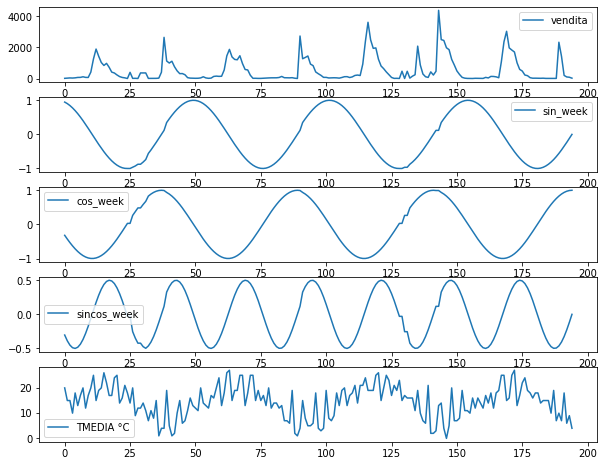

In [20]:
# Plot the data to explore and see what we are working with
for dataset in aug_datasets:
    print(dataset, "data \n")
    # Plot the data with the most correlation to the sales we are trying to predict
    # These are the features we will train the network on later
    values = aug_datasets[dataset].values
    #cols_to_plot = cols_with_most_corr(aug_datasets[dataset], 0)
    cols_to_plot = [0,1,2,3,4]
    
    i=1
    plt.figure(figsize=(10,8))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(values[:, col], label=aug_datasets[dataset].columns[col])
        plt.legend()
        i += 1
    plt.show()

In [21]:
#milan_weekly_augmented.vendita.shift(periods=3, fill_value=0)

In [22]:
## Correlation matrix: Spearman Correlation
#for dataset in aug_datasets:

   #default_s_corr = aug_datasets[dataset].corr(method="spearman")
   #plt.figure(figsize=(10,8))
   #sns.heatmap(data=default_s_corr, cmap="YlOrRd", annot=True, linewidths=.1)
   #plt.title("Correlation for "+ dataset+" data")
   #plt.show()
   #
   #def_p_val_matrix = calculate_pvalues(aug_datasets[dataset], lag=0)
   #plt.figure(figsize=(10,8))
   #sns.heatmap(data=def_p_val_matrix, annot=True, linewidths=.1)
   #plt.title("P-Vals for above correlation data")
   #plt.show()
   #
   #lagged_s_corr = lagged_corr_matrix(milan_weekly_augmented, lag=1)
   #plt.figure(figsize=(10,8))
   #sns.heatmap(data=lagged_s_corr, cmap="YlOrRd", annot=True, linewidths=.1)
   #plt.title("Lagged correlation for "+ dataset + " data")
   #plt.show()
   #
   #lagged_p_val_matrix = calculate_pvalues(aug_datasets[dataset], lag=1)
   #plt.figure(figsize=(10,8))
   #sns.heatmap(data=lagged_p_val_matrix, annot=True, linewidths=.1)
   #plt.title("P-Vals for above correlation data")
   #plt.show()
    
    #feature_cols = cols_with_most_corr(aug_datasets[dataset], 0)
    #for col in feature_cols:
    #    print("P-value of correlation between sales and", aug_datasets[dataset].columns[col], \
    #          ":", p_val_matrix.values[0][col])

# Forecasting evaluation

In [27]:
single_run_results = []
n_runs = 2

for dataset in aug_datasets:
    print("Running forecasting for sales in", dataset)
    curr_def_rmse = curr_def_mae = curr_aug_rmse = curr_aug_mae = 0
    for run in range(n_runs):
        print ("Run #", run+1)
        # Load the default and augmented versions of the data
        aug_dataset = aug_datasets[dataset]
        non_shifted_aug = aug_dataset
        aug_dataset.iloc[:, 1:] = aug_dataset.iloc[:, 1:].shift(-1)
        aug_dataset = aug_dataset.iloc[:-1, :]
        def_dataset = def_datasets[dataset]
        def_dataset = def_dataset.iloc[:-1, :]

        

        # Create training and test data
        def_train, def_test = ts_train_test_split(def_dataset)
        aug_train, aug_test = ts_train_test_split(aug_dataset)
        ns_aug_train, ns_aug_test = ts_train_test_split(non_shifted_aug)

        def_tr_df, def_te_df = prepare_for_network(def_train, def_test)
        aug_tr_df, aug_te_df = prepare_for_network(aug_train, aug_test)
       
        # Extract the columns which display most correlation with the value we are trying to predict.
        # As it can be seen in the 
        default_desired_input_features = cols_with_most_lagged_corr(def_train)
        #aug_desired_input_features = cols_with_most_corr(ns_aug_train)
        aug_desired_input_features = [0, 2, 3, 11, 13]
       
        print("Default input features:", default_desired_input_features)
        print("Input features with exogenous data:", aug_desired_input_features)

        
        
        ## Run STL Decomposition as baseline
        print("Running Drift and Seasonal Drift models based on STL Decomposition...")
        f_steps = def_test.shape[0]-1
        #decomp = decompose(def_train.vendita, period=52)
        #drift_forecast = forecast(decomp, steps=f_steps, fc_func=drift, seasonal=True)
        ##sdrift_forecast = forecast(decomp, steps=f_steps, fc_func=drift, )
        #drift_rmse = sm.tools.eval_measures.rmse(def_test.vendita.values, drift_forecast["drift+seasonal"].values)
        #drift_mae = sm.tools.eval_measures.meanabs(def_test.vendita.values, drift_forecast["drift+seasonal"].values)
        ##sdrift_rmse = sm.tools.eval_measures.rmse(def_test.vendita.values[:f_steps], sdrift_forecast["drift+seasonal"].values)
        ##sdrift_mae = sm.tools.eval_measures.meanabs(def_test.vendita.values[:f_steps], sdrift_forecast["drift+seasonal"].values)
        #print("Done\n")
        #
        ## Run ARIMA as another baseline
        #print("Running SARIMA model...")
        ## Fit your model
        #sarima_model = pm.auto_arima(def_train.vendita, seasonal=True, m=52, suppress_warnings=True, max_order=None, \
        #                            start_p=3, start_q=0, start_P=0, start_Q=0, \
        #                            max_p=6, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1)
        ## Get model params
        #sarima_order = sarima_model.get_params()["order"]
        #sarima_s_order = sarima_model.get_params()["seasonal_order"]
        ## Predict #test steps into the future
        #sarima_forecasts = sarima_model.predict(f_steps)  
        #sarima_rmse = sm.tools.eval_measures.rmse(def_test.vendita.values, sarima_forecasts)
        #sarima_mae = sm.tools.eval_measures.meanabs(def_test.vendita.values, sarima_forecasts)
        #print("Done\n")
        #
        #print("Running SARIMAX model...")
        #sarimax_model = SARIMAX(endog=aug_train.vendita, exog=aug_train.iloc[:, aug_desired_input_features[1:]], \
        #                        order=sarima_order, seasonal_order=sarima_s_order)
        #sarimax_fitted = sarimax_model.fit()
        #sarimax_forecasts = sarimax_fitted.forecast(f_steps, exog=aug_test.iloc[:, aug_desired_input_features[1:]])  
        #sarimax_rmse = sm.tools.eval_measures.rmse(def_test.vendita.values, sarimax_forecasts)
        #sarimax_mae = sm.tools.eval_measures.meanabs(def_test.vendita.values, sarimax_forecasts)
        #print("Done\n")
        
        

        # Run LSTM and Exo-LSTM
        print("Training the default LSTM model...")
        def_opt_obj.train(def_x_train[:,:-1],def_x_train[:,1:],def_x_train[:,:-1],def_x_train[:,1:], do_teacher_forcing=True, n_epochs=len(default_desired_input_features)*10)
        print("Done\n")
        print("Training the augmented Exo-LSTM model...")
        aug_opt_obj.train(aug_x_train[:,:-1],aug_x_train[:,1:],aug_x_train[:,:-1],aug_x_train[:,1:], do_teacher_forcing=True, n_epochs=len(aug_desired_input_features)*10)
        print("Done\n")

        def_pred=def_LSTM_Model(def_x_test, f_steps)
        aug_pred=aug_LSTM_Model(aug_x_test, f_steps)

        # Check results of both forecasts
        def_mean = np.mean(def_train["vendita"].values)
        def_std = np.std(def_train["vendita"].values)
        aug_mean = np.mean(aug_train["vendita"].values)
        aug_std = np.std(aug_train["vendita"].values)
        
        curr_def_rmse, curr_def_mae = check_lstm_forecast_results(def_pred, def_inp_te, def_out_te, def_mean, def_std, out_len=38)
        curr_aug_rmse, curr_aug_mae = check_lstm_forecast_results(aug_pred, aug_inp_te, aug_out_te, aug_mean, aug_std, out_len=38)
        
        fig = go.Figure()
        
        x_labels = list(range(0,f_steps))
        fig.add_trace(go.Scatter(x=x_labels, y=def_out_te[0,:,0]*def_std+def_mean,
                    mode='lines', name='GT'))
        #fig.add_trace(go.Scatter(x=x_labels, y=drift_forecast["drift+seasonal"].values,
        #            mode='lines', name='Drift'))
        #fig.add_trace(go.Scatter(x=x_labels, y=sarima_forecasts,
        #            mode='lines', name='SARIMA'+str(sarima_order)+str(sarima_s_order)))
        #fig.add_trace(go.Scatter(x=x_labels, y=sarimax_forecasts,
        #            mode='lines', name='SARIMAX'+str(sarima_order)+str(sarima_s_order)))
        fig.add_trace(go.Scatter(x=x_labels, y=def_pred[0,:,0].detach().cpu().numpy()*def_std+def_mean,
                    mode='lines', name='LSTM'))
        fig.add_trace(go.Scatter(x=x_labels, y=aug_pred[0,:,0].detach().cpu().numpy()*aug_std+aug_mean,
                    mode='lines', name='Exo-LSTM'))
        # Update plot title and axis titles, then save plot as a HTML File
        fig.update_layout(
            title="Forecast of test set",
            xaxis_title="Time steps",
            yaxis_title="Prediction",
            font=dict(
                family="Courier New, monospace",
                size=16,
                color="#7f7f7f"
            )
        )
        fig.show()
        pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"-sales-results.html")
        #single_run_results.append([dataset, "run "+str(run+1), drift_rmse, sarima_rmse, sarimax_rmse, curr_def_rmse, curr_aug_rmse, \
        #                           drift_mae, sarima_mae, sarimax_mae, curr_def_mae, curr_aug_mae])
        single_run_results.append([dataset, "run "+str(run+1), curr_def_rmse, curr_aug_rmse, \
                                   curr_def_mae, curr_aug_mae])
        print()

Running forecasting for sales in Milan
Run # 1
Default input features: [0, 3]
Input features with exogenous data: [0, 2, 3, 11, 13]
Inputs for training
(65, 54, 2)
Outputs for training
(65, 38, 2)
Inputs for testing
(1, 54, 2)
Outputs for testing
(1, 38, 2)


Inputs for training
(65, 54, 5)
Outputs for training
(65, 38, 5)
Inputs for testing
(1, 54, 5)
Outputs for testing
(1, 38, 5)


Running Drift and Seasonal Drift models based on STL Decomposition...
Training the default LSTM model...
Epoch 1 Train loss: 1.17. Validation loss: 1.14. Avg future: 14.60. Elapsed time: 0.44s.
Epoch 2 Train loss: 1.13. Validation loss: 1.09. Avg future: 20.80. Elapsed time: 0.37s.
Epoch 3 Train loss: 1.08. Validation loss: 1.04. Avg future: 19.40. Elapsed time: 0.43s.
Epoch 4 Train loss: 1.03. Validation loss: 0.99. Avg future: 13.20. Elapsed time: 0.36s.
Epoch 5 Train loss: 0.98. Validation loss: 0.93. Avg future: 20.60. Elapsed time: 0.56s.
Epoch 6 Train loss: 0.92. Validation loss: 0.86. Avg future: 2


Run # 2
Default input features: [0, 3]
Input features with exogenous data: [0, 2, 3, 11, 13]
Inputs for training
(65, 54, 2)
Outputs for training
(65, 38, 2)
Inputs for testing
(1, 54, 2)
Outputs for testing
(1, 38, 2)


Inputs for training
(65, 54, 5)
Outputs for training
(65, 38, 5)
Inputs for testing
(1, 54, 5)
Outputs for testing
(1, 38, 5)


Running Drift and Seasonal Drift models based on STL Decomposition...
Training the default LSTM model...
Epoch 1 Train loss: 1.20. Validation loss: 1.18. Avg future: 23.40. Elapsed time: 0.50s.
Epoch 2 Train loss: 1.16. Validation loss: 1.13. Avg future: 15.80. Elapsed time: 0.75s.
Epoch 3 Train loss: 1.11. Validation loss: 1.08. Avg future: 17.00. Elapsed time: 0.32s.
Epoch 4 Train loss: 1.07. Validation loss: 1.03. Avg future: 18.80. Elapsed time: 0.31s.
Epoch 5 Train loss: 1.03. Validation loss: 0.98. Avg future: 28.80. Elapsed time: 0.31s.
Epoch 6 Train loss: 0.97. Validation loss: 0.91. Avg future: 29.20. Elapsed time: 0.30s.
Epoch 7 Tra

In [28]:
# Results for each run of forecasting
#single_run_results_df = pd.DataFrame(single_run_results, columns=["Dataset", "Run Nr.", "DRIFT RMSE", "SARIMA RMSE", \
#                                                                  "SARIMAX RMSE", "LSTM RMSE", "Exo-LSTM RMSE", \
#                                                                  "DRIFT MAE", "SARIMA MAE", "SARIMAX MAE", "LSTM MAE",\
#                                                                  "Exo-LSTM MAE"])
#
single_run_results_df = pd.DataFrame(single_run_results, columns=["Dataset", "Run Nr.", "LSTM RMSE", "Exo-LSTM RMSE", \
                                                                  "LSTM MAE","Exo-LSTM MAE"])
single_run_results_df

,Dataset,Run Nr.,LSTM RMSE,Exo-LSTM RMSE,LSTM MAE,Exo-LSTM MAE
0,Milan,run 1,689.560295,615.582815,381.736225,338.218609
1,Milan,run 2,566.537721,504.774828,289.794238,253.189555


In [29]:
# Aggregate results
mean_results = single_run_results_df.copy(deep=True)
mean_results = mean_results.groupby(["Dataset"]).agg(np.mean)
mean_results

,LSTM RMSE,Exo-LSTM RMSE,LSTM MAE,Exo-LSTM MAE
Dataset,,,,
Milan,628.049008,560.178822,335.765232,295.704082


ValueError: Could not interpret input 'DRIFT RMSE'

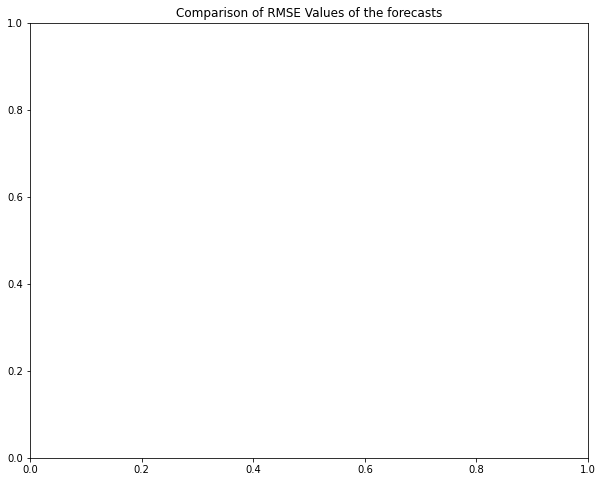

In [26]:
# Graphic comparison of error values: RMSE
plt.figure(figsize=(10,8))
plt.title("Comparison of RMSE Values of the forecasts")
ax = sns.scatterplot(x=mean_results.index, y="DRIFT RMSE", data=mean_results, label="Drift")
ax =sns.scatterplot(x=mean_results.index, y="SARIMA RMSE", data=mean_results, label="SARIMA")
ax = sns.scatterplot(x=mean_results.index, y="SARIMAX RMSE", data=mean_results, label="SARIMAX")
ax = sns.scatterplot(x=mean_results.index, y="LSTM RMSE", data=mean_results, label="LSTM")
ax = sns.scatterplot(x=mean_results.index, y="Exo-LSTM RMSE", data=mean_results, label="Exo-LSTM")
ax.set(ylabel="RMSE")
plt.show()

# Graphic comparison of error values: MAE
plt.figure(figsize=(10,8))
plt.title("Comparison of MAE Values of the forecasts")
aax = sns.scatterplot(x=mean_results.index, y="DRIFT MAE", data=mean_results, label="Drift")
aax = sns.scatterplot(x=mean_results.index, y="SARIMA MAE", data=mean_results, label="SARIMA")
aax = sns.scatterplot(x=mean_results.index, y="SARIMAX MAE", data=mean_results, label="SARIMAX")
aax = sns.scatterplot(x=mean_results.index, y="LSTM MAE", data=mean_results, label="LSTM")
aax = sns.scatterplot(x=mean_results.index, y="Exo-LSTM MAE", data=mean_results, label="Exo-LSTM")
aax.set(ylabel="MAE")
plt.show()

In [ ]:
## Boxplots for error distribution

## Calc errors
#exo_lstm_errors = np.abs(((aug_out_te[:,0,0] * aug_std) + aug_mean ) - ((aug_pred[:,-2,0].detach().cpu().numpy() * aug_std) + aug_mean))
#lstm_errors = np.abs(((def_out_te[:,0,0] * def_std) + def_mean ) - ((def_pred[:,-2,0].detach().cpu().numpy() * def_std) + def_mean))
#arima_errors = np.abs(def_test.vendita.values[:f_steps] - arima_forecasts)
#drift_errors = np.abs(def_test.vendita.values[:f_steps] - drift_forecast.drift.values)
#errors_dict = {
#    "Drift": drift_errors,
#    "ARIMA": arima_errors,
#    "LSTM": lstm_errors,
#    "Exo-LSTM": exo_lstm_errors
#
#}
## Boxplot
#fig, ax = plt.subplots(figsize=(10,8))
#ax.boxplot(errors_dict.values())
#ax.set_xticklabels(errors_dict.keys())
#plt.show()